# Evaluation of ResNet-18 using CIFAR-10
In this notebook we will go through key evaluation metrics for CNN in order to analyse how efficiently and accurately ResNet18 model predicts on data CIFAR-10.

## Setup

In [ ]:
import os, time, torch
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix

from model import TransferModel
from data_preparation.CIFAR_10.data_cifar_10 import test_loader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

Define specific variables for this evaluation script.

In [19]:
model_name = 'ResNet-18'
dataset_name = 'CIFAR-10'
class_labels = test_loader.dataset.classes
class_labels[:8]

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse']

Import data for evaluation taken from training step.

In [20]:
full_history = pd.read_csv('../data_evaluation_resnet18/CIFAR_10/resnet18_cifar10_full_best_training_history.csv')
full_history.columns

Index(['train_loss', 'val_loss', 'val_acc'], dtype='object')

In [21]:
head_history = pd.read_csv('../data_evaluation_resnet18/CIFAR_10/resnet18_cifar10_head_best_training_history.csv')
head_history.columns

Index(['train_loss', 'val_loss', 'val_acc'], dtype='object')

In [22]:
lastblock_history = pd.read_csv(
    '../data_evaluation_resnet18/CIFAR_10/resnet18_cifar10_lastblock_best_training_history.csv')
lastblock_history.columns

Index(['train_loss', 'val_loss', 'val_acc'], dtype='object')

In [23]:
test_loss = pd.read_csv('../data_evaluation_resnet18/CIFAR_10/resnet18_test_loss_list.csv')
test_loss.columns

Index(['batch_loss'], dtype='object')

In [24]:
test_pred = pd.read_csv('../data_evaluation_resnet18/CIFAR_10/resnet18_test_predictions.csv')
y_true = test_pred.True_Label
y_pred = test_pred.Predicted_Label
test_pred.columns

Index(['True_Label', 'Predicted_Label'], dtype='object')

In [25]:
model_path = '../data_evaluation_resnet18/CIFAR_10/resnet18_cifar10_full_best.pth'

## Visualisate Model Predictions

Create instance of our model.

In [26]:
model = TransferModel(num_classes=10, backbone='resnet18', pretrained=False).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

Function to visualisate model predictions (with True and Predicted labels).

In [27]:
def visualize_model_predictions(model, loader, class_labels, target_class=None, num_images=5, device="cpu"):
    samples = [] 
    
    if target_class is not None: 
        target_class_id = class_labels.index(target_class) 
    
    model.eval()
    model.to(device)
    
    with torch.no_grad():
        for images, labels in loader: 
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            preds = outputs.argmax(dim=1)

            # Define filter
            if target_class:
                mask = (labels == target_class_id) & (preds != target_class_id)
            else:
                mask = torch.ones_like(labels, dtype=torch.bool)
            
            # Store matching images
            if mask.any():
                for img, t, p in zip(images[mask], labels[mask], preds[mask]):
                    samples.append((img.cpu(), t.item(), p.item()))
                    if len(samples) >= num_images: break
            
            if len(samples) >= num_images: break
        
    if not samples: return print("No images found.")

    plt.figure(figsize=(15, 4))
    
    plt.suptitle(f'{model_name} using {dataset_name}', fontsize=16, weight='bold', y=1.02)
    for i in range(len(samples)):
        ax = plt.subplot(1, num_images, i + 1)
        
        img_tensor, true_id, pred_id = samples[i]
        img = img_tensor.permute((1, 2, 0)).numpy() 
        
        # Denormalization step
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean # (img - mean) / std
        img = np.clip(img, 0, 1)

        plt.imshow(img)
        
        true_label = class_labels[true_id]
        pred_label = class_labels[pred_id]
        
        # Green for correct, Red for wrong
        color = 'green' if true_id == pred_id else 'red'
        
        ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=color, fontsize=10)
        plt.axis("off")
    plt.show()

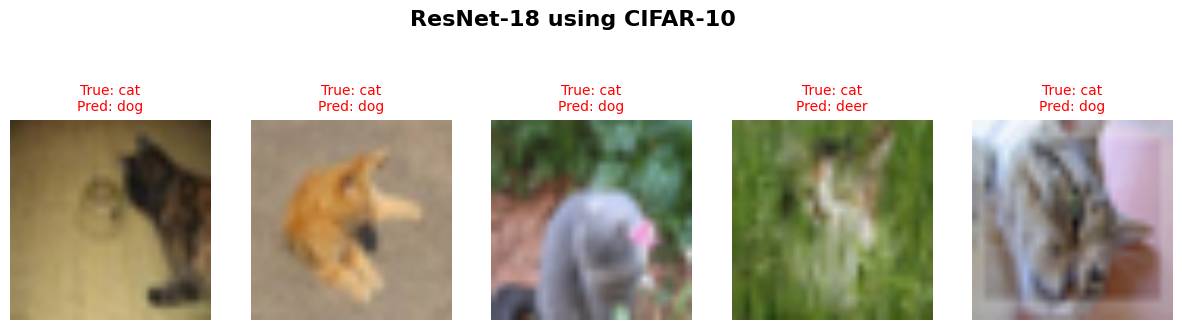

In [28]:
visualize_model_predictions(model, test_loader, class_labels, target_class='cat', num_images=5, device=device)

## Training Dynamics
### Stability & Overfitting Check
In this section we will compare how well model was trained during 3 different transfer learning strategies:
* **Full fine-tuning (full)** -> Training all layers of the network.
* **Linear probing (head)** -> Training only the final classification head while keeping the backbone frozen.
* **Partial fine-tuning (last)** -> Unfreezing the final blocks of the MobileNet architecture to allow for feature adaptation.

In [29]:
# define dictionary to store for each strategy -> name(key), df, color
strategies = {
    "Head Only": {"df": head_history, "color": "#e57373"},
    "Last Block": {"df": lastblock_history, "color": "#ffb74d"},
    "Full Tuning": {"df": full_history, "color": "#81c784"}
}

### Max Accuracy (Top-1 Accuracy)

This metric shows what percentage of the time model's highest-probability prediction matches with actual label.
$$\text{Accuracy} = \frac{1}{N} \sum_{i=1}^{N} \mathbb{1}(\hat{y}_i = y_i)$$

Max accuracy

Head Only: 79.22%
Last Block: 92.68%
Full Tuning: 95.50%


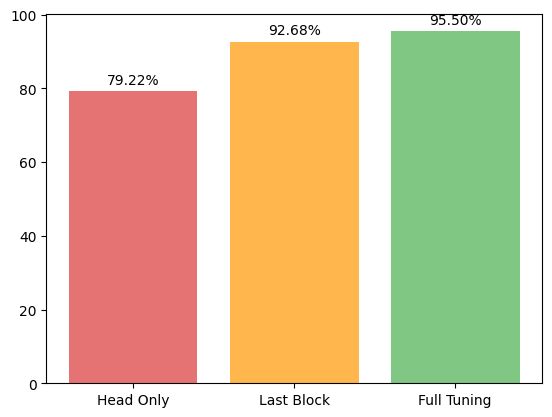

In [ ]:
print("Max accuracy\n")

for key, item in strategies.items():
    item['maxAcc'] = item['df']['val_acc'].max() * 100
    print(f"{key}: {item['maxAcc']:.2f}%")

bars = plt.bar(strategies.keys(), [strategies[i]['maxAcc'] for i in strategies], color=[strategies[i]['color'] for i in strategies])
plt.bar_label(bars, padding=3, fmt='%.2f%%')
plt.suptitle(f'{model_name} using {dataset_name}', fontsize=16, weight='bold', y=1.02)
pass

**Head Only results:** The model works well with a performance of 79.22 percent. This shows that the things it learned from ImageNet are okay but not what we need for the low-resolution images of CIFAR-10. The problem is that if we do not let the model change the part that looks at the images it will not be able to understand the differences that are important, in the new dataset. This means the model that is used for CIFAR-10 will not be as good as it could be. The features of CIFAR-10 are different. The model needs to learn these features of CIFAR-10 to work better.

<br>**Last Block results:** The performance is really good now it has gone up to 92.68%. This is a jump of over 13% from the "Head Only" way of doing things. What this means is that we had to make some changes to the high-level semantic features that the model learned. These features are found in the layers of the model and we had to change them to work well with the 10 classes of CIFAR-10. When we allowed the last block to be changed the model was able to connect the -training data, with the target data in a much better way.

<br>**Full Tuning results:** This strategy yields the best performance at 95.50%. Since the model can adjust all parameters—from simple edge detection in early layers to complex object recognition in later layers—it achieves the most accurate performance for CIFAR-10.

### Combined Validation Accuracy
With this metric we can compare learning capabilities of three strategies of training model.

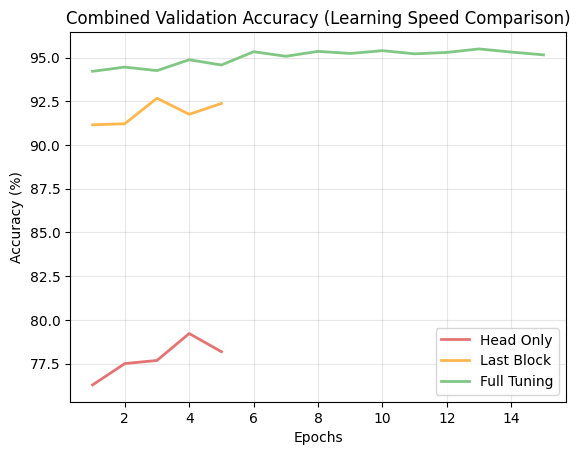

In [ ]:
for key, item in strategies.items():
    df = item['df']
    epochs = range(1, len(df) + 1)
    plt.plot(epochs, df['val_acc'] * 100, label=key, color=item['color'], linewidth=2)

plt.suptitle(f'{model_name} using {dataset_name}', fontsize=16, weight='bold', y=1.02)
plt.title('Combined Validation Accuracy (Learning Speed Comparison)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Head Only Strategy** is not very good. It gets things right 76 to 79 percent of the time. The results are, over the place, which means the Head Only Strategy model has a hard time learning from new information. The Head Only Strategy model reaches its limit fast.

<br>**Last Block Strategy** is really useful. This training strategy makes the convolutional block work again. The Last Block Strategy lets the model learn things that're specific to the dataset. The curve starts high it is above 91 percent. The Last Block Strategy also shows a trend. This proves that changing a few deep layers in the Last Block Strategy does a lot more, than just using a fixed feature extractor.

<br>**Full Tuning Strategy** by unfreezing all layers allows the model to maintain the highest performance stability, consistently hovering above the 94% mark. This is because this strategy allows the model to fully adapt all weights—from low-level edges to high-level shapes—specifically to CIFAR-10.

### Training Loss vs Validation Loss

These graphs will show us how well model generalizes to unseen data depending on which training strategy was used.

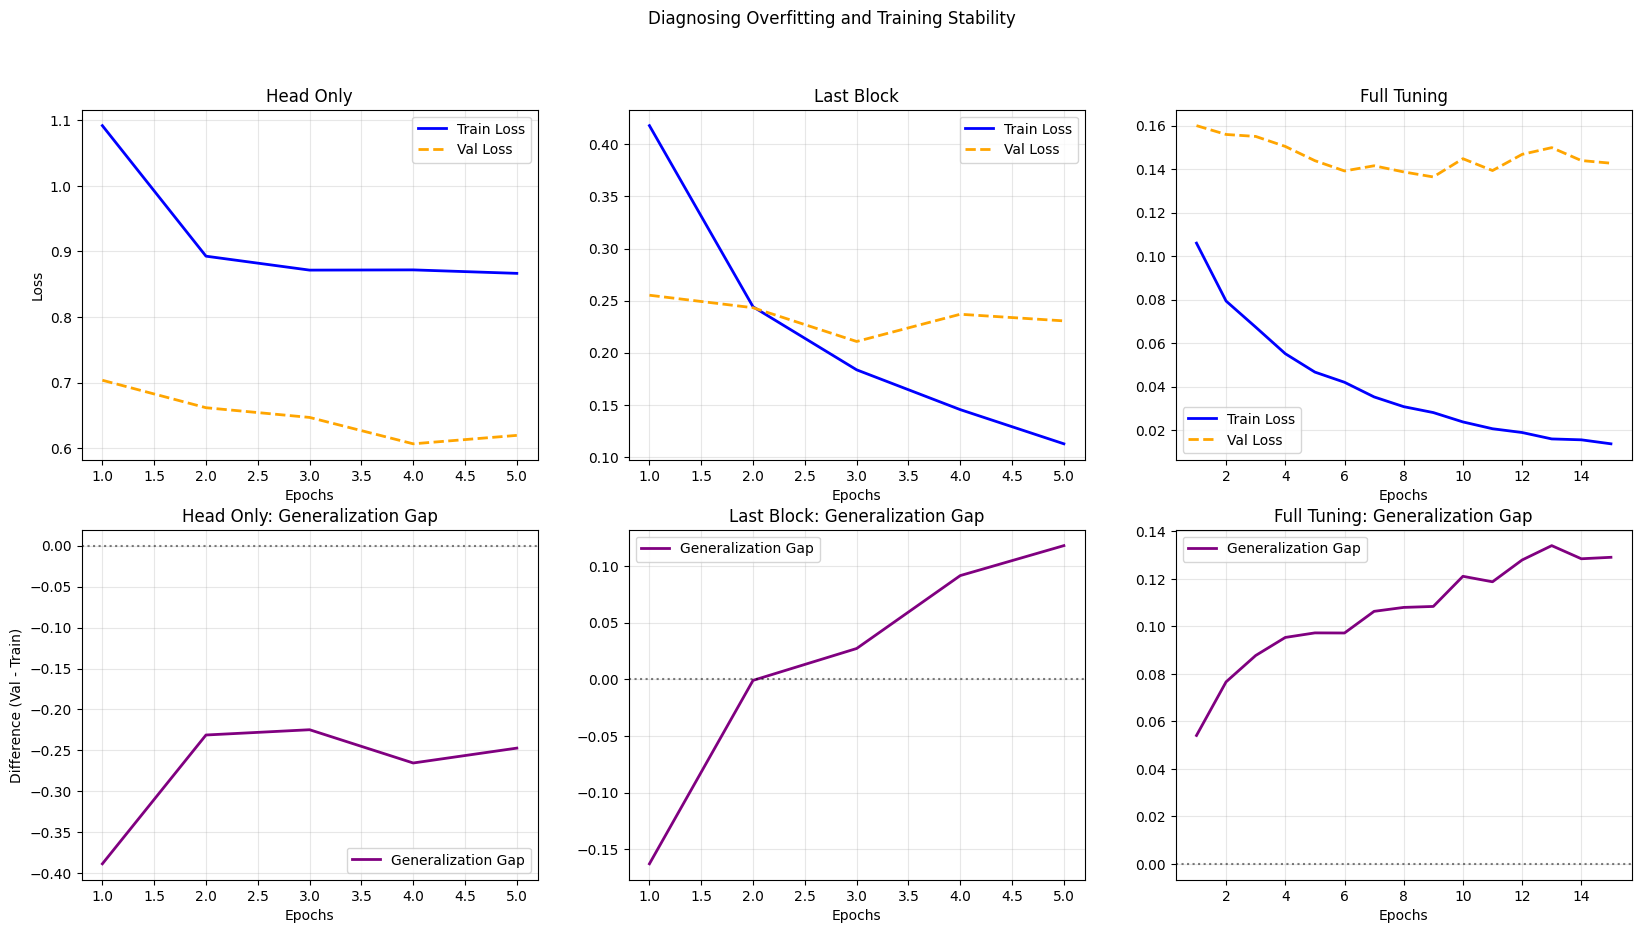

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for ax, (key, item) in zip(axes[0], strategies.items()):
    df = item['df']
    epochs = range(1, len(df) + 1)
    
    #Training Loss
    ax.plot(epochs, df['train_loss'], label='Train Loss', color='blue', linewidth=2)
    
    #Validation Loss
    ax.plot(epochs, df['val_loss'], label='Val Loss', color='orange', linestyle='--', linewidth=2)
    
    ax.set_title(f'{key}', )
    ax.set_xlabel('Epochs')

    if key == "Head Only":  ax.set_ylabel('Loss')

    ax.legend()
    ax.grid(True, alpha=0.3)

#plotting Generalisation Gap Metric
for ax, (key, item) in zip(axes[1], strategies.items()):
    df = item['df']
    epochs = range(1, len(df) + 1)

    # Calculate gap
    df['gap'] = df['val_loss'] - df['train_loss']
    
    ax.plot(epochs, df['gap'], label='Generalization Gap', color='purple', linewidth=2)
    ax.axhline(y=0, color='black', linestyle=':', alpha=0.5)
    
    ax.set_title(f'{key}: Generalization Gap')
    ax.set_xlabel('Epochs')

    if key == "Head Only": ax.set_ylabel('Difference (Val - Train)')
    
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle(f'{model_name} using {dataset_name}\nDiagnosing Overfitting and Training Stability', fontsize=16, weight='bold', y=1.02)
plt.show()

**Head Only:**

* loss curve -> validation loss curve is consistently lower than the training loss curve. So training images are harder to learn.

* generalisation gap -> negative.

> Underfitting -> high bias -> model fails to learn the "hard" training examples effectively because the feature extractor is frozen .


<br>**Last Block:**

* loss curve -> training loss decreases rapidly and crosses the validation loss curve early, at ~epoch 2.

* generalisation gap -> rises from negative and crosses zero at ~epoch 2, growing consistently positive afterwards.

> Rapid Adaptation -> The model's capacity matches the data complexity very quickly (at epoch 2). Unlike the previous run, the gap widens significantly after epoch 2, indicating that the model starts overfitting earlier in this configuration.


<br>**Full Model:**

* loss curve -> validation loss curve is consistently higher than the training loss curve throughout the process.

* generalisation gap -> rises and stays positive (reaching ~0.13).

> Beneficial Overfitting -> high variance -> by the generalization gap (purple curve) we notice the model memorizes training data. However, the superior accuracy (95.50%) confirms we can accept this overfitting to achieve maximum precision.

## High-Level Performance 
### Global Metrics Comparison
Aim is to analyse the model accuracy, precision and f1-score from the best training strategy (by generating theirs distributions).

Function to plot distribution of metrics.

In [ ]:
def print_distribution(df_report, metric:str):
    scores = (df_report[metric] * 100).copy()

    #we drop the global metrics so we only analyze the specific classes (apple, bear, etc.)
    summary_rows = ['accuracy', 'macro avg', 'weighted avg']
    class_scores = scores.drop(summary_rows, errors='ignore')

    # Kernel Density Estimate (KDE) line
    sns.histplot(class_scores, kde=True, bins=15, edgecolor='white', color='#4c72b0')

    # mean performance
    mean_val = class_scores.mean()
    plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean {metric}: {mean_val:.1f}%')

    plt.suptitle(f'{model_name} using {dataset_name}', fontsize=16, weight='bold', y=1.02)
    plt.title(f'Distribution of {metric} Per Class', fontsize=14, weight='bold')
    plt.xlabel(f'{metric} (%)', fontsize=12)
    plt.ylabel('Number of Classes', fontsize=12)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.show()

Global characteristics

In [34]:
# generate report for all 100 classes
report_dict = classification_report(
    y_true, 
    y_pred, 
    target_names=class_labels, 
    output_dict=True
)

df_report = pd.DataFrame(report_dict).transpose()
df_report.head(5)

,precision,recall,f1-score,support
airplane,0.957426,0.967,0.962189,1000.0
automobile,0.971831,0.966,0.968907,1000.0
bird,0.974630,0.922,0.947585,1000.0
cat,0.911111,0.861,0.885347,1000.0
deer,0.945437,0.953,0.949203,1000.0


To get main performance metrics 'classification_report' was used.

In [35]:
report = classification_report(y_true, y_pred, output_dict=True)

print(f"Global Accuracy:    {report['accuracy'] * 100:.2f}%")
print(f"Macro Precision:    {report['macro avg']['precision'] * 100:.2f}%")
print(f"Weighted Precision: {report['weighted avg']['precision'] * 100:.2f}%")
print(f"Macro F1-Score:     {report['macro avg']['f1-score'] * 100:.2f}%")

Global Accuracy:    94.83%
Macro Precision:    94.87%
Weighted Precision: 94.87%
Macro F1-Score:     94.82%


### Precision
This metrics shows us quality or purity of models predictions. High precision means that we can be confident that model identifies images correctly, for low - model labels many things even when they are incorrect, leading to many false alarms.

$$Precision = \frac{TP}{TP + FP}$$
> Out of all the items the model **claimed** to catch, how many were **actually** positive?

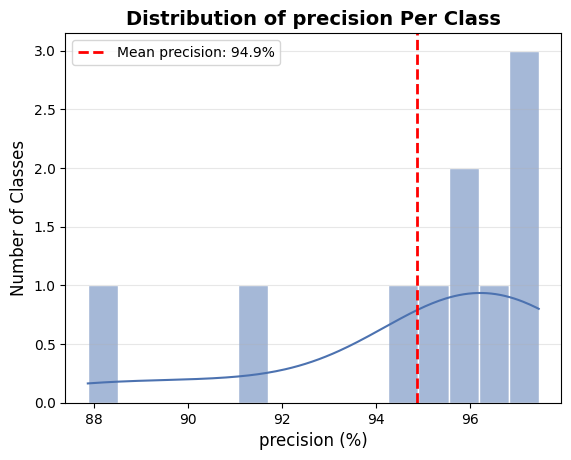

In [36]:
print_distribution(df_report,'precision')

The precision distribution exhibits a strong negative skew with a high mean of 94.9%, indicating that while the majority of classes are classified with near-perfect accuracy (>96%), two specific outlier classes (~88% and ~91%) lag behind, likely due to visual similarities with other categories.

### Recall
This metric measures the "completeness" of your model's predictions. We can find it by the formula:

$$Recall = \frac{TP}{TP + FN}$$

> Out of all the items that are **actually** positive, how many did the model **manage** to catch?

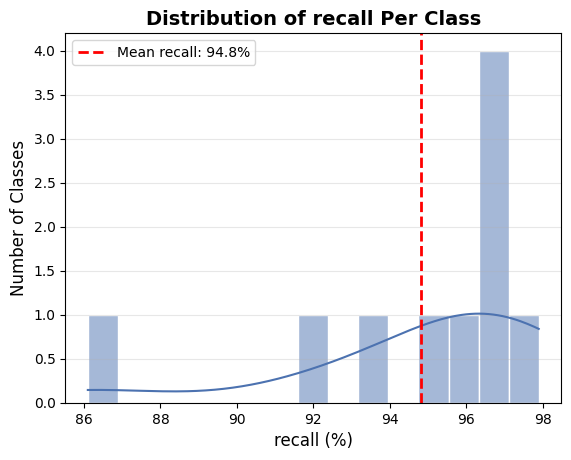

In [37]:
print_distribution(df_report,'recall')

The recall distribution highlights a robust mean sensitivity of 94.8%, driven by a dominant cluster of classes scoring above 96%, though a significant performance gap remains for a single outlier class near 86%.

### F1-Score
$$\text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$
> How well does the model **balance** catching all the **right items** (Recall) while **avoiding wrong** ones (Precision)?

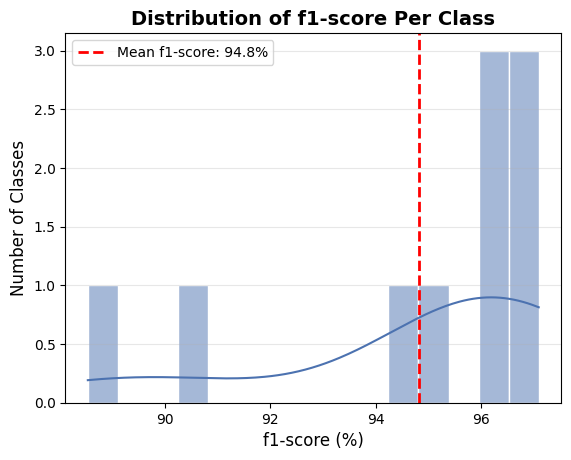

In [38]:
print_distribution(df_report,'f1-score')

The F1-score distribution confirms the model's high reliability with a mean of 94.8%, where most classes cluster in the top-tier performance range (>96%), although two distinct outliers falling between 89% and 91% indicate specific categories where the balance between precision and recall remains suboptimal.

## Class Level Analytics
### Confusion Matrix
Using confusion matrix we can see not only one single score like for accuracy for example, but also we can easily track where and how those mistakes occurred.

<br>In our case for CIFAR-100 we will firstly generate 100 matrices with 2x2 grid. It will show binary implementation of confusion matrices for each class separately. Then we will see confusion matrix in heatmap implementation which will help us to extract top 10 wrongly classified classes.

Binary confusion matrix:
$$\begin{bmatrix}
\text{True Negatives (TN)} & \text{False Positives (FP)} \\
\text{False Negatives (FN)} & \text{True Positives (TP)}
\end{bmatrix}$$

In [39]:
#make y_true and y_pred to have str classes names not numbers
y_true_classes = [class_labels[i] for i in y_true]
y_pred_classes = [class_labels[i] for i in y_pred]

# calculates confusion matrix for each class
overall_confusion_matrix = confusion_matrix(y_true, y_pred)
per_class_confusion_matrices = multilabel_confusion_matrix(y_true_classes, y_pred_classes, labels=class_labels)

n = 3
print(f'Confusion matrices for {n} classes\n')
for i in range(n):
    print(f'{class_labels[i]}')
    print(per_class_confusion_matrices[i],'\n')

Confusion matrices for 3 classes

airplane
[[8957   43]
 [  33  967]] 

automobile
[[8972   28]
 [  34  966]] 

bird
[[8976   24]
 [  78  922]] 



To understand more easily what confusion matrices mean let's analyse one case from above

In [40]:
def print_analytics_of_conf_matrix(cm, target_class):
    target_class_id = class_labels.index(target_class) if type(target_class)==str else target_class
    target_class_name = target_class if type(target_class)==str else target_class

    target_cm = cm[target_class_id]

    print(f'Confusion matrix for {target_class_name}')
    print(target_cm)
    
    indices = [i for i, x in enumerate(y_true) if x == target_class_id] # actual label
    predictions_for_target = [y_pred[i] for i in indices] # predicts

    counts = Counter(predictions_for_target) # count

    print(f"\nWhen image was actually '{target_class_name}', but the model predicted:")
    for pred_id, count in counts.most_common(5):
        print(f" - {class_labels[pred_id]}: {count} times")

In [41]:
print_analytics_of_conf_matrix(per_class_confusion_matrices, 'airplane')

Confusion matrix for airplane
[[8957   43]
 [  33  967]]

When image was actually 'airplane', but the model predicted:
 - airplane: 967 times
 - ship: 20 times
 - truck: 7 times
 - horse: 2 times
 - bird: 2 times


Plot of confusion matrix where rows represents true class label, columns - predicted class and diagonal represents correct predictions. All not diagonal cells represents mistakes.

In [ ]:
def conf_matrix_heatmap(cm, model_name, data_name, dots_to_plot:list[list[int]]=None, class_labels=None):
    sns.heatmap(cm, 
                annot=False, # if true numbers will appear
                cmap='Blues', # color 'Blues' or 'viridis' 
                vmax=20,
                cbar_kws={'label': 'Number of Images'}
                )           
    if dots_to_plot:
        x_coords = []
        y_coords = []

        for true_id, pred_id in dots_to_plot:
            x_coords.append(pred_id + 0.5)  # -> to be in middle of square
            y_coords.append(true_id + 0.5)
            
            print(f"Marking: {class_labels[true_id]} (ID {true_id}) -> {class_labels[pred_id]} (ID {pred_id})")
    
        plt.scatter(x_coords, y_coords, color='red', marker='o', linewidth=2)
    
    plt.suptitle(f'{model_name} using {dataset_name}', fontsize=16, weight='bold', y=1.02)
    plt.xlabel('Predicted Class ID')
    plt.ylabel('True Class ID')
    plt.show()

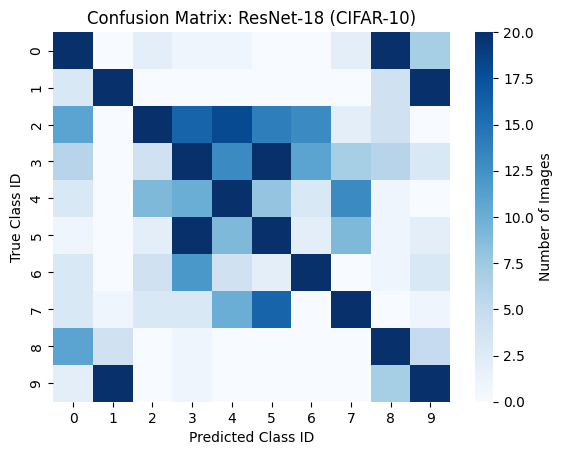

In [43]:
conf_matrix_heatmap(overall_confusion_matrix, model_name,dataset_name)

How we can use confusion matrix?

In [44]:
def get_top_confusions(y_true, y_pred, class_names, top_n=10):
    cm = confusion_matrix(y_true, y_pred)
    np.fill_diagonal(cm, 0) # Zero out correct predictions (diagonal) to find errors
    
    pairs = []
    for i in range(10):
        for j in range(10):
            if cm[i, j] > 0:
                pairs.append((i, j, cm[i, j]))
    
    # Sort in descending order
    pairs.sort(key=lambda x: x[2], reverse=True)
    
    print(f"--- Top {top_n} Confusions ---")
    for i in range(min(top_n, len(pairs))):
        true_idx, pred_idx, count = pairs[i]
        
        t_name = class_names[true_idx] if class_names else str(true_idx)
        p_name = class_names[pred_idx] if class_names else str(pred_idx)
        
        print(f"True: {class_labels.index(t_name)} - {t_name:<15} Predicted: {class_labels.index(p_name)} - {p_name:<15} Count: {count}")
        
get_top_confusions(y_true,y_pred,class_labels)

--- Top 10 Confusions ---
True: 3 - cat             Predicted: 5 - dog             Count: 89
True: 5 - dog             Predicted: 3 - cat             Count: 40
True: 1 - automobile      Predicted: 9 - truck           Count: 27
True: 9 - truck           Predicted: 1 - automobile      Count: 23
True: 0 - airplane        Predicted: 8 - ship            Count: 20
True: 2 - bird            Predicted: 4 - deer            Count: 18
True: 2 - bird            Predicted: 3 - cat             Count: 16
True: 7 - horse           Predicted: 5 - dog             Count: 16
True: 2 - bird            Predicted: 5 - dog             Count: 14
True: 2 - bird            Predicted: 6 - frog            Count: 13


Below we will plot on confusion matrix top 3 wrongly classified classes

Marking: cat (ID 3) -> dog (ID 5)
Marking: dog (ID 5) -> cat (ID 3)
Marking: automobile (ID 1) -> truck (ID 9)
Marking: truck (ID 9) -> automobile (ID 1)


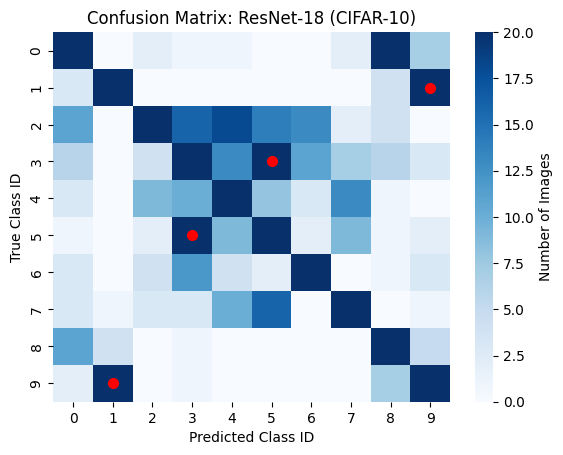

In [49]:
conf_matrix_heatmap(overall_confusion_matrix, model_name,dataset_name, dots_to_plot=[[3,5], [5,3], [1,9], [9,1]], class_labels=class_labels)

We can also see these cases on actual data.

In [50]:
print_analytics_of_conf_matrix(per_class_confusion_matrices, 'automobile')

Confusion matrix for automobile
[[8972   28]
 [  34  966]]

When image was actually 'automobile', but the model predicted:
 - automobile: 966 times
 - truck: 27 times
 - ship: 4 times
 - airplane: 3 times


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x10f676340>
Traceback (most recent call last):
  File "/Users/ira/Documents/VisualStudio/backup/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/Users/ira/Documents/VisualStudio/backup/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/local/Cellar/python@3.12/3.12.12/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/Cellar/python@3.12/3.12.12/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/Cellar/python@3.12/3.12.12/Fram

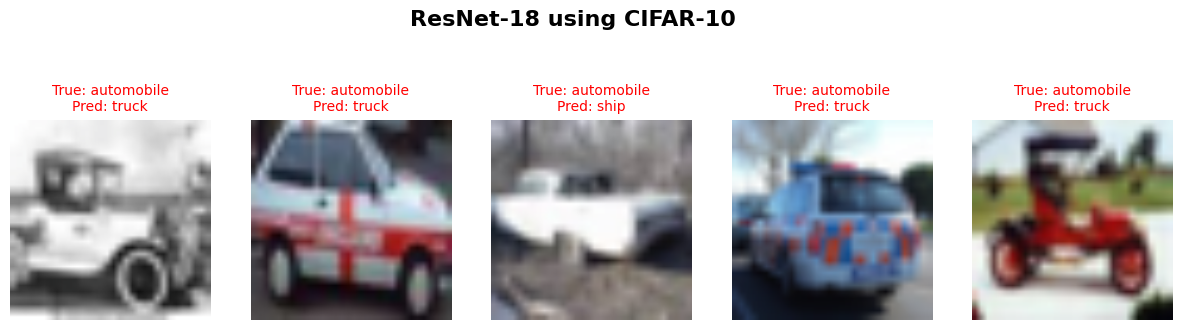

In [51]:
visualize_model_predictions(model,test_loader,class_labels,'automobile')

## Efficiency Analytics
Main idea of this section is to analyse disk space required to store model, how much parameters model has, time of forward pass duration (how much time it takes from the moment an input tensor enters the first layer until the probability vector exits the final layer).

In [ ]:
def get_efficiency_metrics(model, loader, device, model_path):
    model.eval()

    #model size
    size_mb = os.path.getsize(model_path) / (1024 * 1024)

    #total numb of parameters
    params = sum(p.numel() for p in model.parameters())
    
    num_samples = 0
    start_time = time.time()
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device)            
            num_samples += images.size(0)
            
            if i >= 10: break 
            
    end_time = time.time()
    avg_inference_time = (end_time - start_time) / num_samples

    print(f">>> Global Efficiency & Confidence Metrics")
    print(f"Model Size:       {size_mb:.2f} MB")
    print(f"Total Params:     {params:,}")
    print(f"Inference Time:   {avg_inference_time*1000:.2f} ms per image")
  
    return size_mb, params, avg_inference_time
#get_efficiency_metrics(model, test_loader, device, model_path)

## Conclusions

### Training Strategy
The comparison highlights **Full Fine-Tuning** as the definitive strategy for CIFAR-10, though the margins differ from CIFAR-100.
* **Head Only (79.22%)**: While decent, it hit a performance ceiling, proving that ImageNet features need adaptation for low-resolution CIFAR images.
* **Last Block (92.68%)**: Delivered a massive performance jump (+13%), showing that adapting just the high-level semantic layers is highly effective for this dataset.
* **Full Tuning (95.50%)**: Achieved the highest accuracy. The ability to adjust features at all levels (from edges to objects) provided the necessary edge to reach state-of-the-art performance.

### Model Reliability & Balance
The model exhibits exceptional reliability, with **Precision, Recall, and F1-Score all averaging ~95%**.
Unlike CIFAR-100, the performance here is very consistent across classes. The distribution plots show a tight cluster of high-performing classes, with only 1 or 2 slight outliers (likely `cat` or `dog`) dipping below the 90% mark, confirming the model is robust and balanced.

### Error Analysis
The confusion matrix shows that mistakes are rare and logical. The "Top Confusions" are almost exclusively between semantically or visually identical classes:
* **Cat ↔ Dog**: The most common error due to similar body shapes and textures.
* **Automobile ↔ Truck**: Confusions occur here likely due to similar backgrounds (roads) and wheels.
The model has effectively solved the distinct classes (like `Ship` vs `Horse`) and only struggles with the most ambiguous pairs.

### Efficiency
ResNet-18 remains a highly efficient choice. It provides a lightweight footprint (~43 MB) and fast inference times, making it an ideal candidate for real-time applications on this dataset where the trade-off between speed and 95%+ accuracy is favorable.